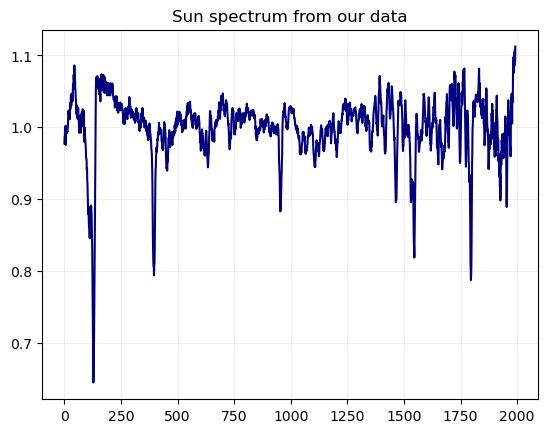

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from imageio import imwrite, imread
from matplotlib.pyplot import figure, show, close, xlabel, ylabel, title
from scipy.constants import k, h, c, e
import sympy as sp
from scipy.optimize import curve_fit
from astropy.visualization import simple_norm, MinMaxInterval

sun_data = np.loadtxt("flatlined/Flatlined_Moon.txt", comments="#")

fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.plot(sun_data, color="navy", label="Vega spectrum")
frame.set_title("Sun spectrum from our data")
frame.grid(alpha=0.2)
show()
close(fig)

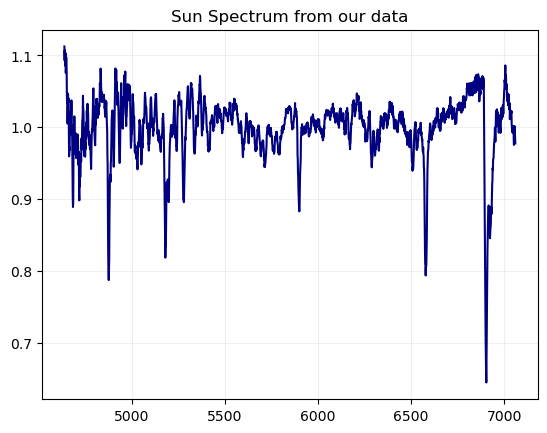

In [67]:
x_range = np.arange(0, np.size(sun_data))
x_range_a = x_range*-1.217+7060

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(x_range_a,sun_data,color="navy", label="Arcturus spectrum") # the section of the data that seems relevant
frame.set_title("Sun Spectrum from our data")
frame.grid(alpha=0.2)
show()
close(fig)

[array([-2.00e-01,  4.88e+03,  5.00e+00]), array([-2.0e-01,  5.2e+03,  5.0e+00]), array([-2.0e-01,  5.9e+03,  5.0e+00]), array([-3.0e-01,  6.6e+03,  5.0e+00]), array([-5.0e-01,  6.9e+03,  5.0e+00])]
Parameters: [-2.11414585e-01  4.87469421e+03  4.66626288e+00 -1.37249344e-01
  5.18434082e+03  1.07251739e+01 -1.22387310e-01  5.89810713e+03
  5.44993809e+00 -2.08291283e-01  6.57876248e+03 -6.87745181e+00
 -2.51480513e-01  6.90933694e+03  1.16925838e+01  1.00777115e+00]
Gaussian parameters: [[-2.11414585e-01  4.87469421e+03  4.66626288e+00]
 [-1.37249344e-01  5.18434082e+03  1.07251739e+01]
 [-1.22387310e-01  5.89810713e+03  5.44993809e+00]
 [-2.08291283e-01  6.57876248e+03 -6.87745181e+00]
 [-2.51480513e-01  6.90933694e+03  1.16925838e+01]]
Line parameters: [1.00777115]


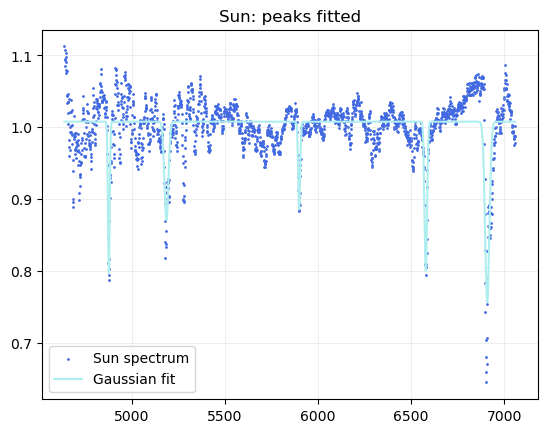

In [68]:
def f_superior(x, *params):
    """Returns a combination of multiple Gaussians plotted on a straight line"""
    num_gaussians = (len(params)-1) // 3
    y = np.zeros_like(x, dtype=float) #it was having some weird type issues
    for i in range(num_gaussians):
        a = params[3 * i]
        m = params[3 * i + 1]
        s = params[3 * i + 2]
        y += a * np.exp(-(x - m) ** 2 / (2.0 * s ** 2))
    z = params[-1:]
    y+=z
    return y

D1=np.array([-0.2,4880,5])
D2=np.array([-0.2,5200,5]) #Na I
D3 = np.array([-0.2,5900,5]) #?
D4 = np.array([-0.3,6600,5]) #Fe I
D5 = np.array([-0.5,6900,5])

# arcturus_miles_line=alsbaseline(arcturus_miles_line, remove=False, lam=1)

initial_gaussians = [D1, D2, D3, D4, D5]
print(initial_gaussians)
initial_guess = [item for sublist in initial_gaussians for item in sublist] + [1]

beta, pcov = curve_fit(f_superior, x_range_a, sun_data, p0=initial_guess)
print("Parameters:", beta) #it's not printing the figure if i remove this line, no idea why

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
z = beta[-1]

# poor attempt at error analysis
# gaussian_params_err = pcov[:num_gaussians * 3].reshape((num_gaussians, 3))
# exp_params_err = pcov[num_gaussians * 3:]
err=np.sqrt(np.diag(pcov))
fwhm_err=2*err[2]*np.sqrt(2*np.log(2))

print("Gaussian parameters:", gaussian_params)
print("Line parameters:", line_params)

# plotting the final fit
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.scatter(x_range_a, sun_data, color="royalblue", label="Sun spectrum", s=1)
frame.plot(x_range_a, f_superior(x_range_a, *beta), color="paleturquoise", label="Gaussian fit")
frame.set_title("Sun: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

[10.98820936 25.25585447 12.83362347 16.19516139 27.53393068]
H-beta peak equivalent width: 10.98820936262828
Mg I peak equivalent width: 25.255854467103823
Na I peak equivalent width: 12.83362346813947
Oxygen peak equivalent width: 16.19516138591169
H-alpha peak equivalent width: 27.53393067513074
Error in FWHMs: 0.8538742214445946


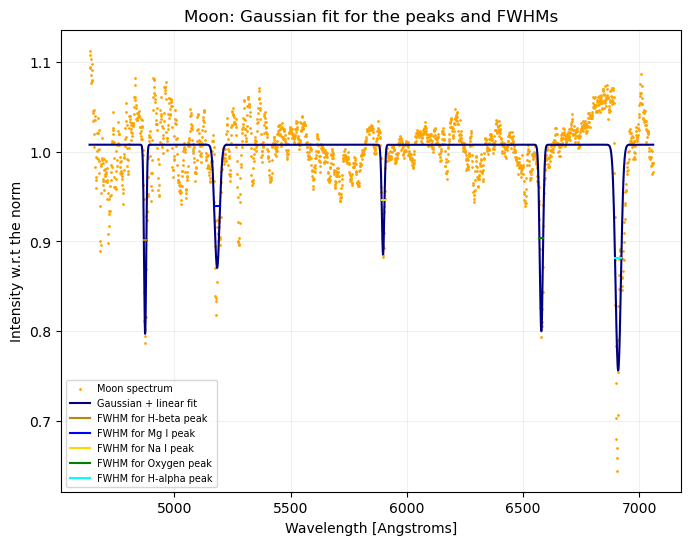

In [69]:
FWHM = np.array([2*np.abs(Peak[2])*np.sqrt(2*np.log(2)) for Peak in gaussian_params])
print(FWHM)

c=0
PeakDescriptions=["H-beta", "Mg I","Na I","Oxygen","H-alpha"]
PeakColors=["darkgoldenrod","blue", "gold", "green", "cyan"]
for Peak in gaussian_params:
    print(f"{PeakDescriptions[c]} peak equivalent width: {FWHM[c]}")
    c+=1

print(f"Error in FWHMs: {fwhm_err}")

# 1.2056420239473526 4615.032805371546

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_a,sun_data, color="orange", label="Moon spectrum",s=1)
frame.plot(x_range_a,f_superior(x_range_a, *beta),color="navy", label="Gaussian + linear fit")

p=0

PeakPositions = []
for Peak in gaussian_params:
    a,m,s=Peak
    PeakPositions.append(m)
    f=FWHM[p]
    fwhm_x=np.array((m-f/2,m+f/2))

    # getting the exponential fit data to know the y-coordinates of FWHM plot
    

    fwhm_y=np.array((a/2+z,a/2+z))

    frame.plot(fwhm_x,fwhm_y,color=PeakColors[p], label=f"FWHM for {PeakDescriptions[p]} peak")
    p+=1

frame.set_title("Moon: Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=7)
show()
close(fig)